<a href="https://colab.research.google.com/github/abiget/birank-and-matrix-factorization-recommendation/blob/main/birank_and_matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Setup

In [81]:
import os
import time
from zipfile import ZipFile
from urllib.request import urlretrieve
from collections import defaultdict
import numpy as np
import pandas as pd
import scipy.sparse as spa
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
from google.colab import drive
import gc

In [82]:
# mount drive
drive.mount('/content/drive')

# Create the directory if it doesn't exist
project_dir = "./drive/MyDrive/Data_Mining/Project"
if not os.path.exists(project_dir):
    os.makedirs(project_dir)
    # create data direcory and img for storing resulting images
    os.makedirs(os.path.join(project_dir, 'data'))
    os.makedirs(os.path.join(project_dir, 'img'))
    print(f"Directory '{project_dir}' created successfully.")
else:
    print(f"Directory '{project_dir}' already exists.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory './drive/MyDrive/Data_Mining/Project' created successfully.


In [83]:
#set working current dir
%cd /content/drive/MyDrive/Data_Mining/Project

/content/drive/MyDrive/Data_Mining/Project


In [84]:
# down load the plot_result(plot utility function) form github if not exist
if not os.path.exists('plot_results.py'):
  !wget https://raw.githubusercontent.com/abiget/birank-and-matrix-factorization-recommendation/refs/heads/main/plot_results.py
# load custom module for ploting
from plot_results import plot_train_progress, plot_rank_metric, plot_rank_metric_both

In [85]:
def download_data(url):
  """
    Download data from url
  """
  filename = os.path.basename(url)
  if not os.path.exists(filename):
    path, _ = urlretrieve(url, filename)
    print("Data downloaded successfuly !")
  else:
    print("Data already downloaded")

download_data('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')
download_data('https://files.grouplens.org/datasets/movielens/ml-1m.zip')

Data already downloaded
Data already downloaded


In [86]:
def extract_data(filename, extract_to_path):
  """
    Extract data into project director
  """
  file_dir = os.path.join(extract_to_path, os.path.basename(filename).split('.')[0])
  # extract file into the project directory
  if not os.path.exists(file_dir)and os.path.exists(filename):
    with ZipFile(filename, 'r') as zf:
      zf.extractall(path=extract_to_path)
      print(f"Extracted to {file_dir} directory")
  else:
    print("Data already extracted")

extract_data("ml-latest-small.zip", './data')
extract_data("ml-1m.zip", './data')

Data already extracted
Data already extracted


# Load Data and EDA

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

The other dataset contain 1,000,209 anonymous ratings of approximately 3,900 movies
made by 6,040 MovieLens users who joined MovieLens in 2000.

In [87]:
data_path10k = 'data/ml-latest-small/'
data_path1m = 'data/ml-1m/'

# Load the 100k dataset
ratings_100k = pd.read_csv(os.path.join(data_path10k, 'ratings.csv'))
movies_100k = pd.read_csv(os.path.join(data_path10k, 'movies.csv'))

# Load the 1M dataset
ratings_1m = pd.read_csv(os.path.join(data_path1m, 'ratings.dat'), sep='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])
movies_1m = pd.read_csv(os.path.join(data_path1m, 'movies.dat'), sep='::', engine='python', encoding='latin-1', names=['movieId', 'title', 'genres'])

In [88]:
ratings_100k.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [89]:
movies_100k.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [90]:
ratings_1m.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [91]:
movies_1m.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [92]:
# Merge ratings with movies for 100k dataset
ratings_with_titles_100k = pd.merge(ratings_100k, movies_100k, on='movieId')

# Merge ratings with movies for 1M dataset
ratings_with_titles_1m = pd.merge(ratings_1m, movies_1m, on='movieId')

In [93]:
def min_max_num_ratings_per_user(ratings):
    user_rating_counts = ratings.groupby('userId')['rating'].count()
    min_ratings = user_rating_counts.min()
    max_ratings = user_rating_counts.max()
    return min_ratings, max_ratings

min_ratings_100k, max_ratings_100k = min_max_num_ratings_per_user(ratings_100k)
min_ratings_1m, max_ratings_1m = min_max_num_ratings_per_user(ratings_1m)

print(f"Min # of ratings per user 100K: {min_ratings_100k}")
print(f"Max # of ratings per user 100K: {max_ratings_100k}")
print("")
print(f"Min # of ratings per user 1M: {min_ratings_1m}")
print(f"Max # of ratings per user 1M: {max_ratings_1m}")

Min # of ratings per user 100K: 20
Max # of ratings per user 100K: 2698

Min # of ratings per user 1M: 20
Max # of ratings per user 1M: 2314


In [94]:
def min_rating_count(ratings, min_count=20):
    user_counts = ratings['userId'].value_counts()
    filtered_users = user_counts[user_counts <= min_count]
    return filtered_users.shape[0]
min_count = 20
print(f"Number of users with {min_count} ratings in ratings_100k: {min_rating_count(ratings_100k)}")
print(f"Number of users with {min_count} ratings in ratings_1m: {min_rating_count(ratings_1m)}")

Number of users with 20 ratings in ratings_100k: 14
Number of users with 20 ratings in ratings_1m: 86


In [95]:
def check_null_values(ratings):
    null_counts = ratings.isnull().sum()
    return null_counts

def check_duplicates(ratings):
    return ratings.duplicated().sum()

print(f"# null values 100K:\n{check_null_values(ratings_100k)}\n")
print(f"# null values 1M:\n{check_null_values(ratings_1m)}\n")
print("")
print(f"# duplicates 100K: {check_duplicates(ratings_100k)}")
print(f"# duplicates 1M:  {check_duplicates(ratings_1m)}")

# null values 100K:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

# null values 1M:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


# duplicates 100K: 0
# duplicates 1M:  0


In [96]:
def unique_users_items(ratings):
    unique_users = ratings['userId'].nunique()
    unique_items = ratings['movieId'].nunique()
    return unique_users, unique_items

def num_not_rated_movies(ratings, movies):
    not_rated = movies[~movies['movieId'].isin(ratings['movieId'].unique())].shape[0]
    return not_rated

unique_users_100k, unique_items_100k = unique_users_items(ratings_100k)
unique_users_1m, unique_items_1m = unique_users_items(ratings_1m)

not_rated_movies_100k = num_not_rated_movies(ratings_100k, movies_100k)
not_rated_movies_1m = num_not_rated_movies(ratings_1m, movies_1m)

print(f"# unique users 100K: {unique_users_100k}")
print(f"# unique items 100K: {unique_items_100k}")
print("")
print(f"# unique users 1M: {unique_users_1m}")
print(f"# unique items 1M: {unique_items_1m}")
print("")
print(f"# movies not rated 100K: {not_rated_movies_100k}")
print(f"# movies not rated 1M: {not_rated_movies_1m}")

# unique users 100K: 610
# unique items 100K: 9724

# unique users 1M: 6040
# unique items 1M: 3706

# movies not rated 100K: 18
# movies not rated 1M: 177


In [97]:
def rating_distribution(ratings):
    rating_counts = ratings['rating'].value_counts().sort_index()
    return rating_counts

rating_counts_100k = rating_distribution(ratings_100k)
rating_counts_1m = rating_distribution(ratings_1m)

print(f"Rating distribution 100K:\n{rating_counts_100k}")
print("")
print(f"Rating distribution 1M:\n{rating_counts_1m}")

Rating distribution 100K:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

Rating distribution 1M:
rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


In [98]:
def top_10_mean_rating_per_user(ratings):
    mean_ratings = ratings.groupby('userId')['rating'].mean().sort_values(ascending=False).head(10)
    return mean_ratings

top_10_mean_ratings_100k = top_10_mean_rating_per_user(ratings_100k)
top_10_mean_ratings_1m = top_10_mean_rating_per_user(ratings_1m)

print(f"Top_10_Mean rating per user 100K:\n{top_10_mean_ratings_100k}")
print("")
print(f"Top_10_Mean rating per user 1M:\n{top_10_mean_ratings_1m}")

Top_10_Mean rating per user 100K:
userId
53     5.000000
251    4.869565
515    4.846154
25     4.807692
30     4.735294
523    4.693333
348    4.672727
171    4.634146
452    4.556931
43     4.552632
Name: rating, dtype: float64

Top_10_Mean rating per user 1M:
userId
283     4.962963
2339    4.956522
3324    4.904762
3902    4.890909
446     4.843137
447     4.837838
4649    4.818182
4634    4.813725
1131    4.796117
4925    4.761905
Name: rating, dtype: float64


In [99]:
def most_rated_rating(ratings):
    most_rated = ratings['rating'].value_counts().idxmax()
    return most_rated

def num_movies_rated_three_or_more(ratings):
    num_movies = (ratings['rating'] >= 3.0).sum()
    return num_movies

most_rated_rating_100k = most_rated_rating(ratings_100k)
most_rated_rating_1m = most_rated_rating(ratings_1m)
num_movies_rated_three_or_more_100k = num_movies_rated_three_or_more(ratings_100k)
num_movies_rated_three_or_more_1m = num_movies_rated_three_or_more(ratings_1m)

print(f"Most rated rating 100K: {most_rated_rating_100k}")
print(f"Most rated rating 1M: {most_rated_rating_1m}")
print("")
print(f"# movies rated 3.0 or more 100K: {num_movies_rated_three_or_more_100k}")
print(f"# movies rated 3.0 or more 1M: {num_movies_rated_three_or_more_1m}")

#rated less than three
rated_less_than_three_100k = ratings_100k.shape[0] - num_movies_rated_three_or_more_100k
rated_less_than_three_1m = ratings_1m.shape[0] - num_movies_rated_three_or_more_1m
print(f"# movies rated less than 3.0 100K: {rated_less_than_three_100k}")
print(f"# movies rated less than 3.0 1M: {rated_less_than_three_1m}")

Most rated rating 100K: 4.0
Most rated rating 1M: 4

# movies rated 3.0 or more 100K: 81763
# movies rated 3.0 or more 1M: 836478
# movies rated less than 3.0 100K: 19073
# movies rated less than 3.0 1M: 163731


In [100]:
def plot_rating_distribution(ratings10K, ratings1M, title10K, title1M):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the countplot for the 100K dataset
    sns.countplot(x='rating', data=ratings10K, hue='rating', palette='viridis', ax=axes[0], legend=False)
    axes[0].set_title(f'Distribution of Ratings - {title10K}')
    axes[0].set_xlabel('Rating')
    axes[0].set_ylabel('Count')
    plt.tight_layout()

    # Plot the countplot for the 1M dataset
    sns.countplot(x='rating', data=ratings1M, hue='rating', palette='viridis', ax=axes[1], legend=False)
    axes[1].set_title(f'Distribution of Ratings - {title1M}')
    axes[1].set_xlabel('Rating')
    axes[1].set_ylabel('Count')
    plt.tight_layout()
    plt.savefig(f'img/rating_distribution.eps')
    plt.show()

def plot_top_rated_movies(ratings_with_titles, title, n=10):
    top_rated_movies = ratings_with_titles['title'].value_counts().head(n)
    plt.figure(figsize=(6, 4))
    sns.barplot(y=top_rated_movies.index, x=top_rated_movies.values, hue=top_rated_movies.index, palette='viridis', legend=False)
    plt.title(f'Top {n} Most Rated Movies - {title}')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Movie Title')
    plt.show()

def plot_top_active_users(ratings10K, ratings1M, title10K, title1M, n=10):
    top_active_users10K = ratings10K['userId'].value_counts().head(n)
    top_active_users1M = ratings1M['userId'].value_counts().head(n)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the countplot for the 100K dataset
    sns.barplot(y=top_active_users10K.index, x=top_active_users10K.values, hue=top_active_users10K.values, palette='viridis', legend=False, ax=axes[0])
    axes[0].set_title(f'Top {n} Most Active Users - {title10K}')
    axes[0].set_xlabel('Number of Ratings')
    axes[0].set_ylabel('User ID')
    plt.tight_layout()

    # Plot the countplot for the 1M dataset
    sns.barplot(y=top_active_users1M.index, x=top_active_users1M.values, hue=top_active_users1M.values, palette='viridis', legend=False, ax=axes[1])
    axes[1].set_title(f'Top {n} Most Active Users - {title1M}')
    axes[1].set_xlabel('Number of Ratings')
    axes[1].set_ylabel('User ID')
    plt.tight_layout()
    plt.savefig(f'img/top_active_users.eps')
    plt.show()

def plot_least_active_users(ratings10K, ratings1M, title10K, title1M, n=10):

    least_active_users10K = ratings10K['userId'].value_counts().tail(n)
    least_active_users1M = ratings1M['userId'].value_counts().tail(n)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the countplot for the 100K dataset
    sns.barplot(y=least_active_users10K.index, x=least_active_users10K.values, hue=least_active_users10K.values, palette='viridis', legend=False, ax=axes[0])
    axes[0].set_title(f'Top {n} least Active Users - {title10K}')
    axes[0].set_xlabel('Number of Ratings')
    axes[0].set_ylabel('User ID')
    plt.tight_layout()

    # Plot the countplot for the 1M dataset
    sns.barplot(y=least_active_users1M.index, x=least_active_users1M.values, hue=least_active_users1M.values, palette='viridis', legend=False, ax=axes[1])
    axes[1].set_title(f'Top {n} least Active Users - {title1M}')
    axes[1].set_xlabel('Number of Ratings')
    axes[1].set_ylabel('User ID')
    plt.tight_layout()
    plt.savefig(f'img/least_active_users.eps')
    plt.show()

def plot_top_avg_rated_movies(ratings_with_titles, title, n=10):
    avg_rating_per_movie = ratings_with_titles.groupby('title')['rating'].mean().sort_values(ascending=False).head(n)
    plt.figure(figsize=(6, 4))
    sns.barplot(y=avg_rating_per_movie.index, x=avg_rating_per_movie.values, hue=avg_rating_per_movie.index, palette='viridis', legend=False)
    plt.title(f'Top {n} Movies by Average Rating - {title}')
    plt.xlabel('Average Rating')
    plt.ylabel('Movie Title')
    plt.show()

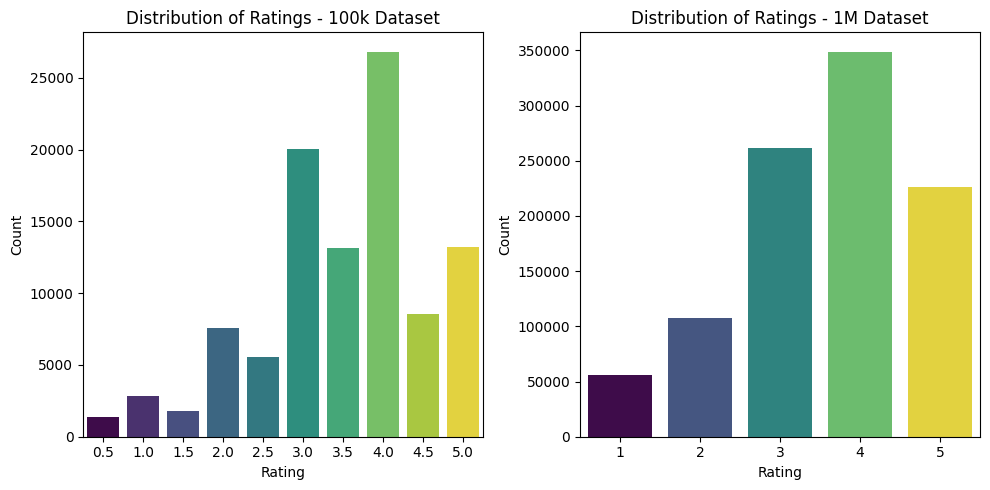

In [101]:
# rating distribution for both datasets
plot_rating_distribution(ratings_100k, ratings_1m, '100k Dataset', '1M Dataset')

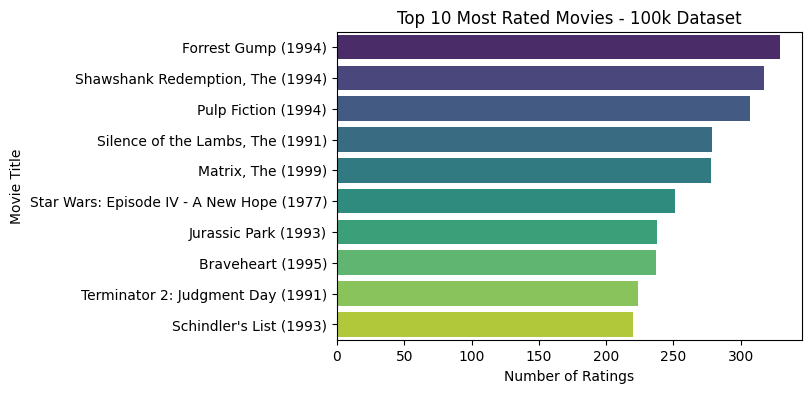

In [102]:
#top 20 most rated movies for both datasets
# 100k Dataset
plot_top_rated_movies(ratings_with_titles_100k, '100k Dataset')

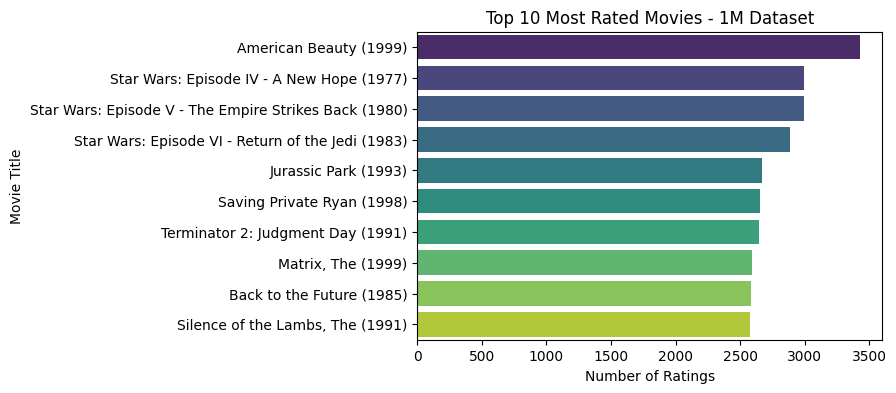

In [103]:
# 1M Dataset
plot_top_rated_movies(ratings_with_titles_1m, '1M Dataset')

<ipython-input-104-7cf69fd0d50c>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-104-7cf69fd0d50c>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


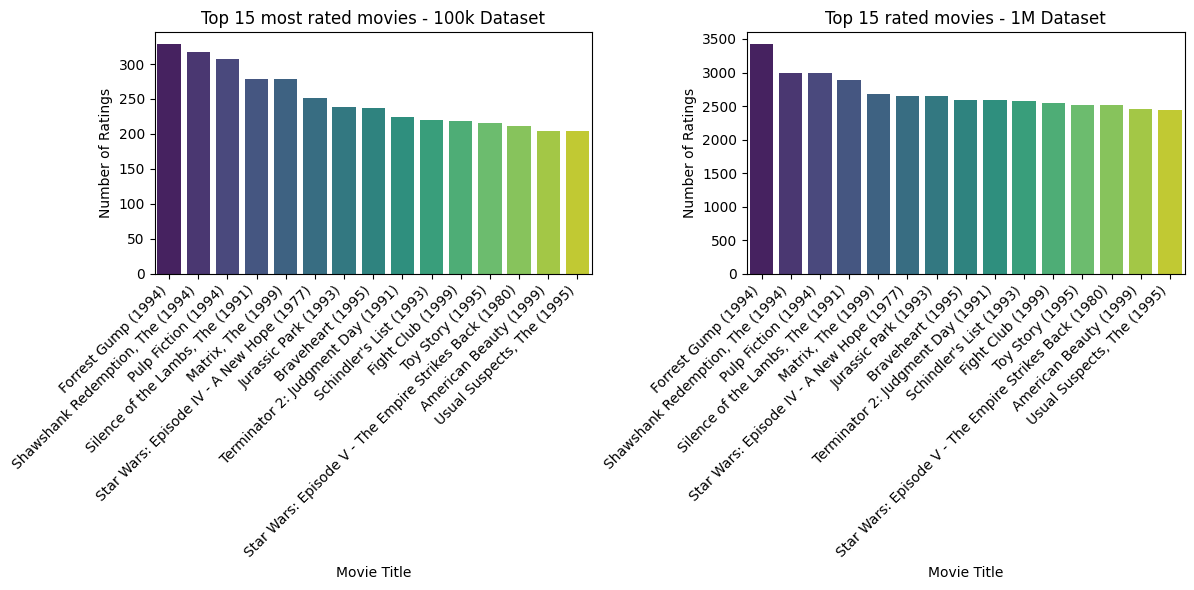

In [104]:
# combine top N most rated movies
def plot_top_rated_movies_count(ratings_with_titles100K, ratings_with_titles10M, title10k, title1M, n=15):
    top_rated_movies100K = ratings_with_titles100K['title'].value_counts().head(n)
    top_rated_movies1M = ratings_with_titles10M['title'].value_counts().head(n)

    # Plots top N most rated movies.
    fig, axes= plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(x=top_rated_movies100K.index, y=top_rated_movies100K.values, palette='viridis', hue=top_rated_movies100K.index, legend=False, ax=axes[0])
    axes[0].set_title(f'Top {n} most rated movies - {title10k}')
    axes[0].set_xlabel('Movie Title')
    axes[0].set_ylabel('Number of Ratings')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()

    # Plots top N most rated movies dataset.
    sns.barplot(x=top_rated_movies1M.index, y=top_rated_movies1M.values, palette='viridis', hue=top_rated_movies1M.index, legend=False, ax=axes[1])
    axes[1].set_title(f'Top {n} rated movies - {title1M}')
    axes[1].set_xlabel('Movie Title')
    axes[1].set_ylabel('Number of Ratings')
    axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'img/top_rated_movies_count.eps')
    plt.show()

plot_top_rated_movies_count(ratings_with_titles_100k, ratings_with_titles_1m,  '100k Dataset', '1M Dataset')

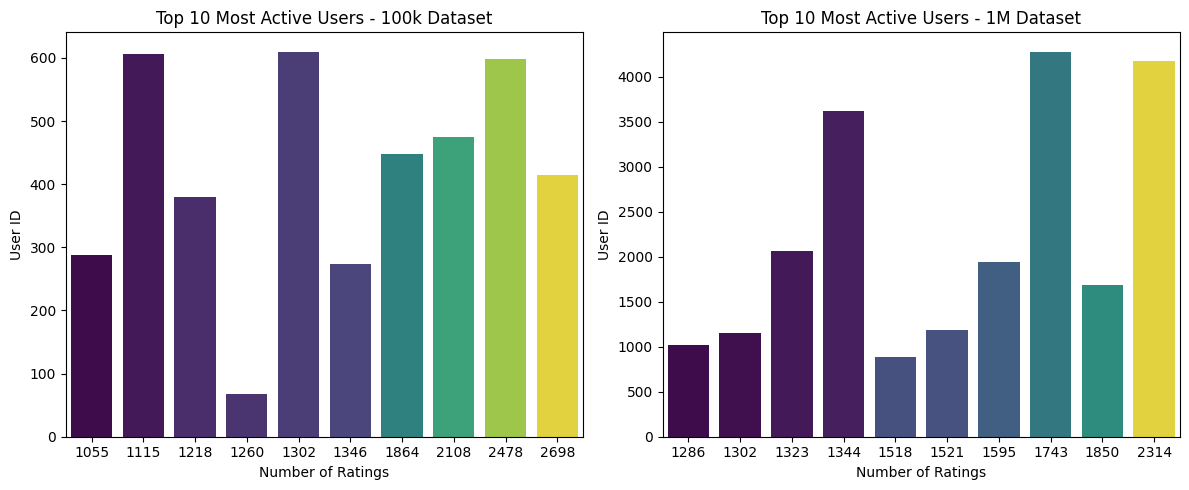

In [105]:
#top 20 most active users for both datasets
plot_top_active_users(ratings_100k, ratings_1m, '100k Dataset', '1M Dataset')

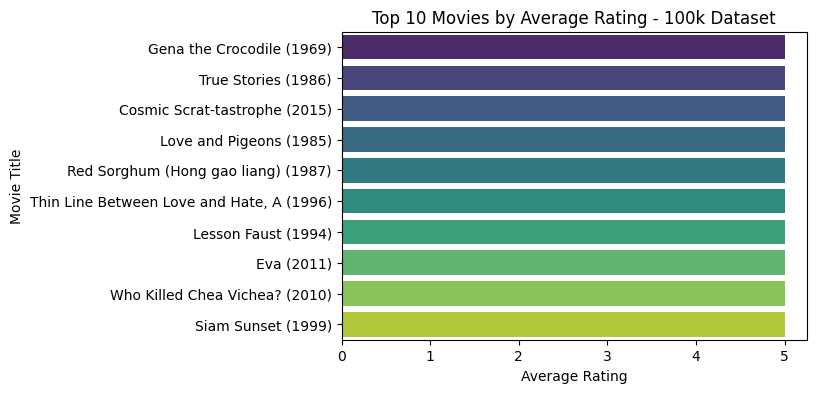

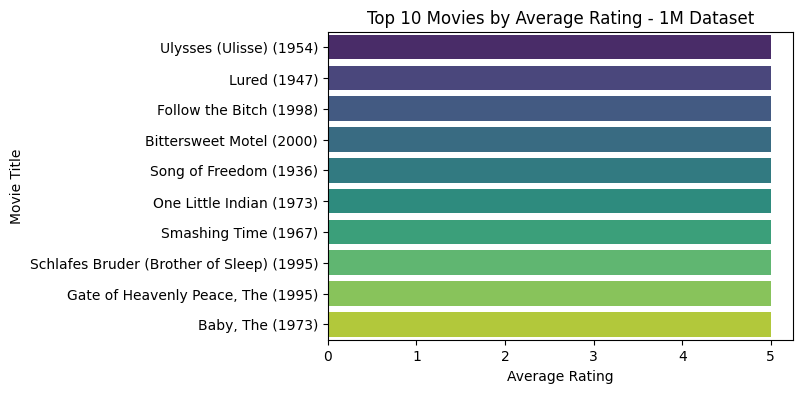

In [106]:
#top 20 movies by average rating for both datasets
plot_top_avg_rated_movies(ratings_with_titles_100k, '100k Dataset')
plot_top_avg_rated_movies(ratings_with_titles_1m, '1M Dataset')

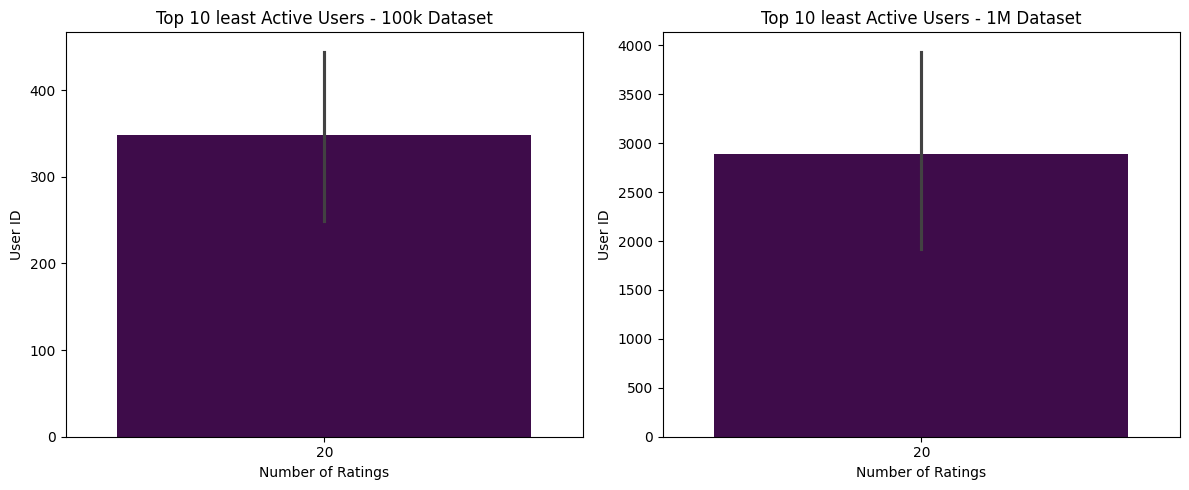

In [107]:
#top 20 least active users for both datasets with only 20 ratings
plot_least_active_users(ratings_100k, ratings_1m, '100k Dataset', '1M Dataset')

#Birank personalization

**Algorithm: The Iterative BiRank Algorithm**



**Input:** Weight matrix \( W \), query vectors \( p<sub>0</sub> \), \(u<sub>0</sub>), and hyper-parameters \(&alpha;, &beta; \)  
**Output:** Ranking vectors \( **p**, **u** \)  

1.  Symmetrically normalize \( W \):
  \[
   S = D<sub>u</sub><sup>-1/2</sup> W D<sub>p</sub><sup>-1/2</sup>
   \]
2.   Randomly initialize \( **p** \) and \( **u** \)
3. **while** Stopping criteria is not met **do**  
   \[
   p &larr; &alpha; S<sup>T</sup> u + (1 - &alpha;) p<sub>0</sub>
   \];  
   \[
   u &larr; &beta; S p + (1 - &beta;) u<sup>0</sup>
   \];
4. **end**
5. **return** \( ***p*** \) and \( ***u*** \)


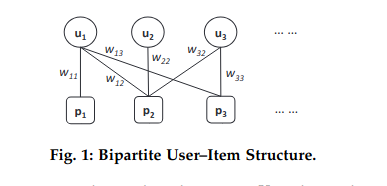

Reference:

He, X., Gao, M., Kan, M.-Y., & Wang, D. (2017). BiRank: Towards Ranking on Bipartite Graphs (No. arXiv:1708.04396). arXiv. https://doi.org/10.48550/arXiv.1708.04396


In [108]:
def birank(W, U0, P0, alpha=0.85, beta=0.85, max_iter=200, tol=1e-6, verbose=False):
    """
    A BiRank algorithm implementation for bipartite graph ranking.

    Args:
      W (coo_matrix) : Weight matrix for users and items (n_users x n_items).
      U0 (dia_matrix): Query matrix for users (n_users x n_users).
      P0 (coo_matrix): Query matrix for items (n_users x n_items).
      alpha, beta: hyper-parameters (Damping factors)
      max_iter: Maximum number of iterations
      tol: Tolerance for convergence
      verbose: If True, print the iteration information

    Returns:
      U (csr_matrix): Ranking matrix of users (n_users x n_users).
      P (csr_matrix): Ranking matrix of items for each user (n_users x n_items).
      errors (dict): Dictionary of errors for each iteration.
    """

    errors = {
        "item_error": [],
        "user_error": []
    }

    # Compute the row-sum and col-sum of weight maxtrix
    du = np.asarray(W.sum(axis=1)).ravel()
    dp = np.asarray(W.sum(axis=0)).ravel()

    # avoid division by zero
    eps = 1e-6
    # du = np.maximum(du, eps)
    # dp = np.maximum(dp, eps)
    du[du == 0] = eps
    dp[dp == 0] = eps

    # inverse square root of the row-sum and col-sum and form diagonal matrix
    du_inv_sqrt = spa.diags(1 / np.sqrt(du)).tocsr()
    dp_inv_sqrt = spa.diags(1 / np.sqrt(dp)).tocsr()

    #Symmetrically normalized weight matrix and convert it into csr for efficient matrix multiplication for update rule
    S = du_inv_sqrt @ W @ dp_inv_sqrt
    S = S.tocsr()
    St = S.T

    #initalize the user and item as query matrices
    U_last = U0.copy()
    P_last = P0.copy()

    for itr in range(max_iter):
        # update rules for items and users
        P = alpha * (St @ U_last).T + (1 - alpha) * P0
        U = beta * (S @ P_last.T) + (1 - beta) * U0

        # compute the frobinus norm to get the errors from the previous
        p_error = la.norm((P - P_last).toarray(), ord="fro")
        u_error = la.norm((U - U_last).toarray(), ord="fro")

        errors["item_error"].append(p_error)
        errors["user_error"].append(u_error)

        if verbose:
            print(f"Iteration: {itr}, Item Rank Error: {p_error :.7f}, User Rank Error: {u_error :.7f}")

        if p_error < tol and u_error < tol:
            print(f"converged after {itr} iterations")
            break
        P_last, U_last = P, U

    return U, P, errors

In [109]:
def generate_birank(W, verbose=False):
  """
    generate birank

    Args:
      W: A sparse matrix of users and movies (n_users x num_items)
      U0: A sparse matrix of users and users (n_users x n_users)
      P0: A sparse matrix of user and items (n_users x num_items)

    Returns:
      U: A sparse matrix of users and users (n_users x n_users)
      P: A sparse matrix of users and items (n_users x num_items)
  """

  U0 = spa.eye(W.shape[0]).tocsr()
  P0 = W.copy().tocsr()
  return birank(W, U0, P0, verbose=verbose)

In [110]:
def generate_unique_index(data_df, user_col_name, item_col_name):
    """
    Create unique index for users and items

    Args:
        data_df: A pandas dataframe of users, items, and ratings
        user_col_name: column name of the users
        item_col_name: column name of the items

    Returns:
        data_df: A pandas dataframe with added user_index and item_index columns
    """
    # Create user index mapping
    user_ids = (data_df[user_col_name]
                .unique()
                .reshape(-1,1))
    user_ids = pd.DataFrame(user_ids, columns=[user_col_name])
    user_ids['user_index'] = range(len(user_ids))

    # Create item index mapping
    item_ids = (data_df[item_col_name]
                .unique()
                .reshape(-1,1))
    item_ids = pd.DataFrame(item_ids, columns=[item_col_name])
    item_ids['item_index'] = range(len(item_ids))

    # Merge indexes back to original dataframe
    data_df = (data_df
               .merge(user_ids, on=user_col_name, how='left')
               .merge(item_ids, on=item_col_name, how='left'))

    # collect garbage to free some space
    del user_ids
    del item_ids
    gc.collect()

    return data_df

In [111]:
def create_adj_matrix(data_df, user_index_col, item_index_col, weight_col_name, shape = None, normalize=False, verbose=False) -> spa.coo_matrix:
  """
    create adjacency matrix

    Args:
      data_df: A pandas dataframe of users, movies, and ratings
      user_col_name: column name of the users
      item_col_name: column name of the movies
      weight_col_name: column name of the ratings

    Returns:
      W: scipy.sparse.csr_matrix sparse matrix of users and movies
  """

  # Determine the shape of the matrix
  if shape is None:
    n_users = data_df[user_index_col].max() + 1
    n_items = data_df[item_index_col].max() + 1
    shape = (n_users, n_items)

  weights = data_df[weight_col_name].values

  # Normalize the weights if needed but not used for the experiments
  if normalize:
    weights = (weights - weights.mean() / weights.std())


  #initalize coo_matrix for faster init
  W = spa.coo_matrix(
    (
      weights,
      (data_df[user_index_col].values, data_df[item_index_col].values)
    ),
    shape=shape
  ).tocsr()

  if verbose:
    print(f"Matrix shape: {W.shape}")
    print(f"Memory usage: {W.data.nbytes / (1024 ** 2)} MB")

  return W

In [112]:
#set user, item, weight col names
user_col = 'userId'
item_col = 'movieId'
# generate unique indexes for users and movies(items)
movie_ratings_all_df = generate_unique_index(ratings_with_titles_100k, user_col, item_col)

In [113]:
def custom_train_test_split(data_df, test_size=0.1, min_ratings=3, random_state=42):
    #split the data into test and train by picking test_size ratings per user randomly for testing; the rest for training
    np.random.seed(random_state)

    test_df = data_df.groupby("userId").apply(lambda x: x.sample(int(test_size*len(x))), include_groups=False).reset_index(drop=False).drop(columns=["level_1"])

    #remove those entries in the test_df
    train_df = data_df.merge(test_df[["userId", "movieId"]], on=["userId", "movieId"], how="left", indicator=True)
    train_df = train_df[train_df["_merge"] == "left_only"].drop(columns=["_merge"])

    return train_df, test_df

In [114]:
train_df, test_df = custom_train_test_split(movie_ratings_all_df)
#num unique users in test
print(test_df.userId.nunique())
#num unique users in train
print(train_df.userId.nunique())

610
610


In [115]:
# train and test size
train_df.shape, test_df.shape

((91018, 8), (9818, 8))

In [116]:
def combine_rank_phase(data_df, weight_col = 'rating',
                item_index_col = 'item_index',
                user_index_col = 'user_index'
    ):
    #set weight col
    weight_col = 'rating'

    #set user and item index col names
    item_index_col = 'item_index'
    user_index_col = 'user_index'

    # create adjacency matrix
    W = create_adj_matrix(data_df, user_index_col, item_index_col, weight_col)

    # Generate BiRank scores
    U, P, errors = generate_birank(W, verbose=True)

    return U, P, W, data_df, errors

In [117]:
def generate_personalized_recommendations(W, P):
    interaction_mask = (W > 0).toarray()

    # Mask the recommendation matrix P; collect only items users haven't interacted for recommendation
    P_masked = np.where(interaction_mask, -np.inf, P.toarray())

    return np.argsort(-P_masked, axis=1)

In [118]:
def get_top_n_recommendations(W, P, top_n=None):
    recommendations = generate_personalized_recommendations(W, P)
    return recommendations[:, :top_n] if top_n else recommendations

In [119]:
start = time.time()
U, P, W, _, errors = combine_rank_phase(train_df)
print(f"Time taken: {(time.time() - start) / 60 :.4f} min")
print(f"W: {W.shape}, U: {U.shape}, P: {P.shape}")

Iteration: 0, Item Rank Error: 933.1357466, User Rank Error: 460.1056682
Iteration: 1, Item Rank Error: 339.4410915, User Rank Error: 395.9010807
Iteration: 2, Item Rank Error: 289.0872469, User Rank Error: 277.8296765
Iteration: 3, Item Rank Error: 233.2475808, User Rank Error: 236.2553417
Iteration: 4, Item Rank Error: 198.2859074, User Rank Error: 197.3148695
Iteration: 5, Item Rank Error: 167.3747075, User Rank Error: 167.7258137
Iteration: 6, Item Rank Error: 142.2715205, User Rank Error: 142.1353088
Iteration: 7, Item Rank Error: 120.7608521, User Rank Error: 120.8162262
Iteration: 8, Item Rank Error: 102.6472391, User Rank Error: 102.6239608
Iteration: 9, Item Rank Error: 87.2205523, User Rank Error: 87.2305930
Iteration: 10, Item Rank Error: 74.1375715, User Rank Error: 74.1331493
Iteration: 11, Item Rank Error: 63.0112417, User Rank Error: 63.0132238
Iteration: 12, Item Rank Error: 53.5595773, User Rank Error: 53.5586754
Iteration: 13, Item Rank Error: 45.5244687, User Rank Er

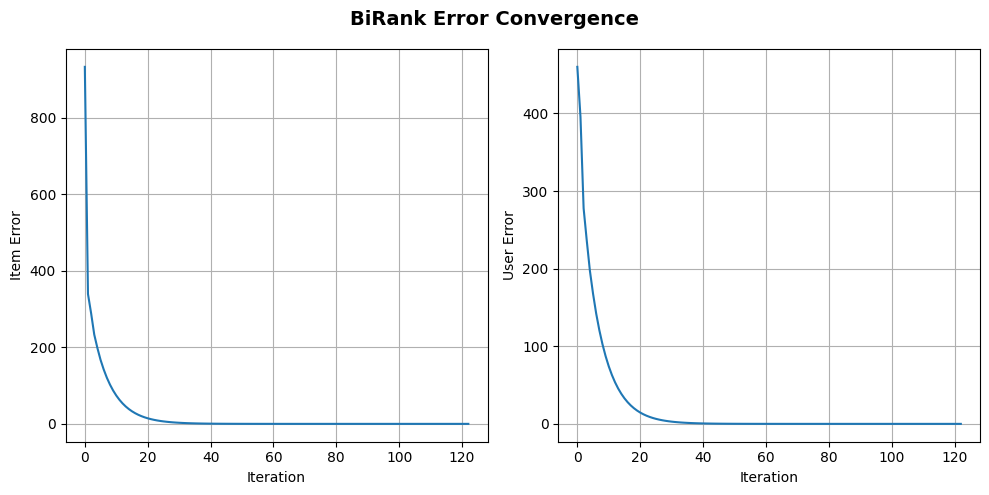

In [120]:
def plot_birank_convergence(errors):
    # plot item and user error
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    fig.suptitle('BiRank Error Convergence', fontsize=14, fontweight='bold')
    axes[0].plot(errors["item_error"], label="Item Error")
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Item Error')
    axes[0].grid(True)

    axes[1].plot(errors["user_error"], label="User Error")
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('User Error')
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('./img/birank_convergence.eps')
    plt.show()
plot_birank_convergence(errors)

In [121]:
def calculate_metrics(test_df, W, P, relevance_threshold=3, top_n=100):
    """
    Calculate HR@N, NDCG@N, and MRR for recommendations

    Args:
        test_df: DataFrame containing test interactions
        W: User-item interaction matrix
        P: BiRank recommendation matrix
        top_n: Number of top items to consider

    Returns:
        Dictionary containing HR@N, NDCG@N, and MRR values
    """

    metrics = {}
    top_n_recommendations = get_top_n_recommendations(W, P, top_n)

    hits = 0
    ndcg_scores = []
    reciprocal_ranks = []
    precisions = []

    # Get unique users for proper averaging
    unique_users = test_df['user_index'].unique()
    total_users = len(unique_users)

    for user_idx in unique_users:
        # Extract all test interactions for this user
        user_test = test_df[test_df['user_index'] == user_idx]
        # Filter items to only those with ratings >= relevance_threshold
        relevant_test = user_test[user_test['rating'] >= relevance_threshold]

        # if the user is new or not exist
        if user_idx >= len(top_n_recommendations):
            continue

        user_recs = top_n_recommendations[user_idx]

        # For rating-based evaluation, you might want the actual ratings too.
        # Create a dictionary: {item_index: rating} for all relevant items.
        actual_ratings_dict = relevant_test.set_index('item_index')['rating'].to_dict()

        # Calculate user-specific metrics
        user_metrics = calculate_user_metrics(user_recs, actual_ratings_dict, top_n)

        # Accumulate metrics across users
        if user_metrics['hit']:
            hits += 1
        ndcg_scores.append(user_metrics['ndcg'])
        reciprocal_ranks.append(user_metrics['rr'])
        precisions.append(user_metrics['precision'])

    # Calculate final metrics
    metrics['HR@N'] = hits / total_users if total_users > 0 else 0
    metrics['NDCG@N'] = np.mean(ndcg_scores)
    metrics['MRR'] = np.mean(reciprocal_ranks)
    metrics['Precision@N'] = np.mean(precisions)

    return metrics


def calculate_user_metrics(recommendations, actual_ratings, top_n):
    """
    Calculate metrics for a single user
    """
    metrics = {'hit': False, 'ndcg': 0.0, 'rr': 0.0, 'precision': 0.0}

    dcg = 0
    idcg = 0
    precision = 0

    # get actual items from the keys of actual_ratings dictionary
    actual_items = set(actual_ratings.keys())

    # For each recommendation, if it is relevant
    for rank, item in enumerate(recommendations, 1):
        if item in actual_items:
            metrics['hit'] = True
            precision += 1

            # Set the reciprocal rank if this is the first relevant item
            if metrics['rr'] == 0:
                metrics['rr'] = 1.0 / rank

            # Use the actual rating as the relevance score for DCG
            relevance = actual_ratings.get(item, 0)
            dcg += relevance / np.log2(rank + 1)

    # Compute the ideal DCG (IDCG) by sorting the actual ratings in descending order.
    # Only consider up to top_n items.
    sorted_ratings = sorted(actual_ratings.values(), reverse=True)

    for i, rel in enumerate(sorted_ratings[:top_n], start=1):
        idcg += rel / np.log2(i + 1)

    # Avoid division by zero in NDCG
    metrics['ndcg'] = dcg / idcg if idcg > 0 else 0

    # Precision
    metrics['precision'] = precision / top_n

    return metrics

def evaluate_complete(test_df, W, P, top_ns=[5, 10, 20, 50, 100]):
    """
    Evaluate recommendations with multiple N values

    Args:
        test_df: Test data
        W: User-item interaction matrix
        P: BiRank recommendation matrix
        top_ns: List of N values to evaluate

    Returns:
        Nested dictionary with metrics for each N value
    """
    results = {}

    for n in top_ns:
        metrics = calculate_metrics(test_df, W, P, relevance_threshold=3, top_n=n)
        results[f'top_{n}'] = metrics

    return results

In [122]:
def print_evaluation_results(results):
    """
    print the evaluation results
    """
    print("\nEvaluation Results:")
    print("-" * 50)
    for n, metrics in results.items():
        print(f"\nMetrics for {n}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")


Evaluation Results:
--------------------------------------------------

Metrics for top_5:
HR@N: 0.4590
NDCG@N: 0.1584
MRR: 0.2693
Precision@N: 0.1492

Metrics for top_10:
HR@N: 0.5672
NDCG@N: 0.1661
MRR: 0.2833
Precision@N: 0.1148

Metrics for top_20:
HR@N: 0.6787
NDCG@N: 0.1839
MRR: 0.2910
Precision@N: 0.0902

Metrics for top_50:
HR@N: 0.7885
NDCG@N: 0.2160
MRR: 0.2948
Precision@N: 0.0608

Metrics for top_100:
HR@N: 0.8410
NDCG@N: 0.2417
MRR: 0.2955
Precision@N: 0.0420


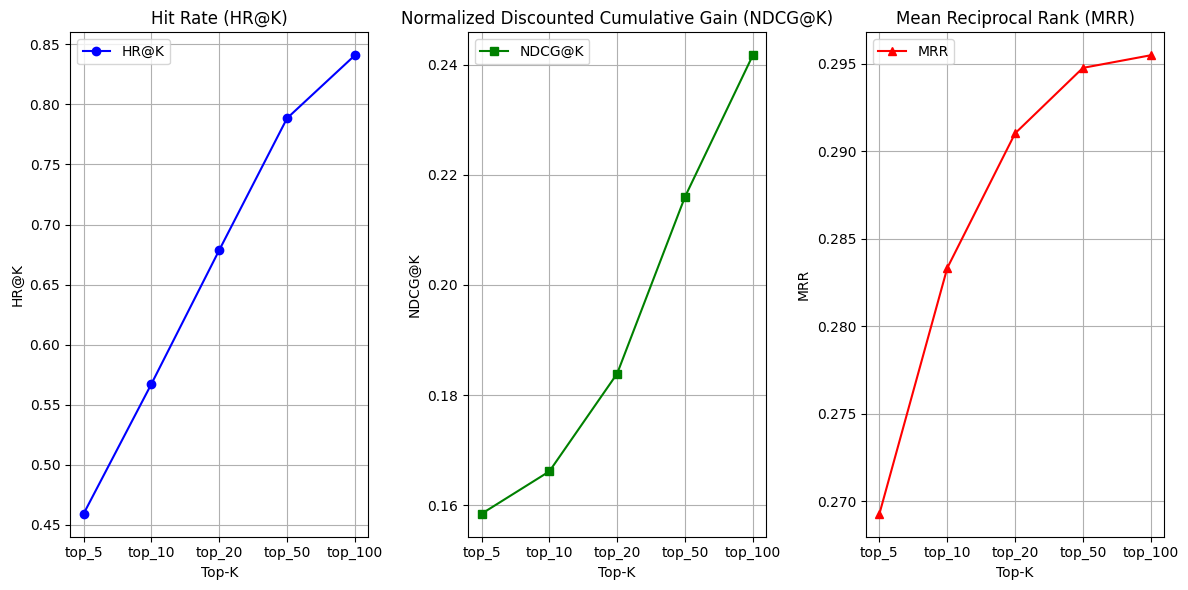

In [123]:
# After the algorithm process plot results and evaluations
test_results_birank = evaluate_complete(test_df, W, P)
print_evaluation_results(test_results_birank)
plot_rank_metric(test_results_birank, './img/birank_evaluation')

**Demo**

In [124]:
# get top n recommendations
top_n_recommendations = get_top_n_recommendations(W, P, top_n=10)
top_n_recommendations.shape

(610, 10)

In [125]:
# filter recommedation for a given user
def filter_results(user_id, data_df):
    user_index = data_df[data_df["userId"] == int(user_id)]["user_index"].unique().item()
    return data_df[data_df["item_index"].isin(top_n_recommendations[user_index])][["movieId", "title", "genres"]].drop_duplicates()

In [126]:
item_input = widgets.Text(
    value='User id',
    description='User Id:',
    disabled=False
)
item_list = widgets.Output()

def on_type(data):
    with item_list:
        item_list.clear_output()
        user_id = data["new"]
        if len(user_id.strip()) > 0 and user_id.isnumeric() and ('top_n_recommendations' in globals()):
            if int(user_id) > 0:
                recommendation_list = filter_results(user_id, test_df)
                display(recommendation_list if len(recommendation_list) > 0 else "User Id not exist")

item_input.observe(on_type, names='value')


display(item_input, item_list)

Text(value='User id', description='User Id:')

Output()

#Matrix Factorization with gradient descent

In [127]:
def prepare_data_temporal_latest(ratings_df, test_item_size=0.2, random_state=42):
    """
    Prepare train and test datasets: split data
    randomy by taking test_item_size latest rated items for testing from each user using the timestamp column
    since it is not performing well on this split; i didn't include in the evaluation.
    """
    np.random.seed(random_state)

    # Create rating matrix
    user_movie_pivot = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0)
    R = user_movie_pivot.values
    movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(user_movie_pivot.columns)}

    # Initialize masks
    mask = R > 0
    train_mask = mask.copy()
    test_mask = np.zeros_like(mask)

    # For each user, select test_item_size latest rated items for testing
    for u in range(R.shape[0]):
        user_ratings_df = ratings_df[ratings_df['userId'] == (u + 1)]  # userId is 1-based in the DataFrame
        test_size = int(test_item_size * len(user_ratings_df))
        if len(user_ratings_df) > test_size:
            # Sort by timestamp (latest first)
            user_ratings_sorted = user_ratings_df.sort_values(by=['timestamp'], ascending=False)['movieId'].values

            # Map movieIds to R matrix column indices
            test_indices = [movie_id_to_index[movie_id] for movie_id in user_ratings_sorted[:test_size]]

            # Update masks
            train_mask[u, test_indices] = False
            test_mask[u, test_indices] = True

    # Create train and test matrices
    R_train = R.copy()
    R_train[~train_mask] = 0

    R_test = R.copy()
    R_test[~test_mask] = 0

    return R_train, R_test

In [128]:
def prepare_data(ratings_df, test_size=0.2, random_state=42):
    """
      Prepare train and test datasets: split data
      randomy by taking test_size percent from each user for testing
    """

    np.random.seed(random_state)

    R = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0).values

    # mask ratings
    mask = R != 0
    train_mask = mask.copy()
    test_mask = np.zeros_like(mask)

    # take test_size percent of each user to test set
    for u in range(R.shape[0]):
      user_ratings = np.where(mask[u])[0]

      if len(user_ratings) > 0:
        test_indices = np.random.choice(user_ratings, size=int(test_size*len(user_ratings)), replace=False)
        train_mask[u, test_indices] = False
        test_mask[u, test_indices] = True

    R_train = R.copy()
    R_train[~train_mask] = 0

    R_test = R.copy()
    R_test[~test_mask] = 0

    return R_train, R_test

In [129]:
class MatrixFact:
  """
    Matrix Factorization with gradient descent, momentum included as an optional to control overfitting
    this is a serial implementation by taking each rating as a train
  """
  def __init__(self, latent_dim=12, epochs=1000, learning_rate=0.005, reg_param=0.12, momentum=0.5, verbos=True, rate_start=1, rate_end=5) -> None:
    self.latent_dim = latent_dim
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.reg_param = reg_param
    self.momentum = momentum
    self.best_factors = None
    self.history = dict(loss=[], train_rmse=[], test_rmse=[], lr=[])
    self.verbos = verbos
    self.rate_start = rate_start
    self.rate_end = rate_end
    print(f"Parametters:\
          latent_dim: {self.latent_dim}, epochs: {self.epochs}, learning_rate: {self.learning_rate},\
          reg_param: {self.reg_param}, momentum: {self.momentum}, verbos: {self.verbos}")

  def _init_factors(self, num_users, num_items):
    """Initialize factor matrices"""
    self.user_factors = np.random.normal(scale=1./self.latent_dim, size=(num_users, self.latent_dim))
    self.item_factors = np.random.normal(scale=1./self.latent_dim, size=(num_items, self.latent_dim))
    self.user_momentum = np.zeros_like(self.user_factors)
    self.item_momentum = np.zeros_like(self.item_factors)


  def fit(self, R_train, R_test):
    """Train the model"""
    self.num_users, self.num_items = R_train.shape
    self._init_factors(self.num_users, self.num_items)

    # training mask and indices
    train_mask = R_train != 0
    train_indices = np.argwhere(train_mask)

    #normalize train rating
    self.global_mean = np.mean(R_train[train_mask])
    R_norm = R_train.copy()
    R_norm[train_mask] = (R_train[train_mask] - self.global_mean)

    # init best_test rmse as infiity, patience for early stoping, patience counter
    best_test_rmse = float('inf')
    patience = 10
    patience_counter = 0

    for step in range(self.epochs):
      total_error = 0
      np.random.shuffle(train_indices)
      current_lr = self.learning_rate


      for u, i in train_indices:
        pred = np.dot(self.user_factors[u, :], self.item_factors[i, :])
        err = R_norm[u, i] - pred

        # update gradients
        user_grad = err * self.item_factors[i, :] - self.reg_param * self.user_factors[u, :]
        item_grad = err * self.user_factors[u, :] - self.reg_param * self.item_factors[i, :]

        # apply momentum
        self.user_momentum[u, :] = self.momentum * self.user_momentum[u, :] + current_lr * user_grad
        self.item_momentum[i, :] = self.momentum * self.item_momentum[i, :] + current_lr * item_grad

        self.user_factors[u, :] += self.user_momentum[u, :]
        self.item_factors[i, :] += self.item_momentum[i, :]

        # Calculate total error including regularization for bias terms
        total_error += err ** 2 + self.reg_param * (np.sum(self.user_factors[u, :] ** 2) + np.sum(self.item_factors[i, :] ** 2))

      # every two iteration log the progress
      if step % 2 == 0:
        train_rmse = self.calculate_rmse(R_train)
        test_rmse = self.calculate_rmse(R_test)
        self.history['loss'].append(total_error)
        self.history['train_rmse'].append(train_rmse)
        self.history['test_rmse'].append(test_rmse)
        self.history['lr'].append(current_lr)

        if self.verbos:
          print(f"Epoch: {step},\t Loss: {total_error :.4f},\t Train RMSE: {train_rmse :.4f},\
          Test RMSE: {test_rmse :.4f}, Diff: {(test_rmse - train_rmse) :.5f}, LR: {current_lr :.6f}")

        # take best factors each time
        if test_rmse < best_test_rmse:
          best_test_rmse = test_rmse
          self.best_factors = (self.user_factors.copy(), self.item_factors.copy())
          patience_counter = 0
        else:
          patience_counter += 1

        #check early stoping
        if patience_counter >= patience:
          print(f"\nEarly stopping at step {step}")
          break

  def predict_all(self):
    """Predict all ratings"""
    predictions = np.dot(self.user_factors, self.item_factors.T)
    return np.clip((predictions + self.global_mean), self.rate_start, self.rate_end)

  def predict(self, user_idx, item_idx):
    """Predict rating for a specific user-item pair"""
    prediction = np.dot(self.user_factors[user_idx, :], self.item_factors[item_idx, :])
    return np.clip((prediction + self.global_mean), self.rate_start, self.rate_end)

  def calculate_rmse(self, R):
    """Calculate RMSE for given ratings matrix"""
    mask = R != 0
    predictions = self.predict_all()
    squared_errors = (R[mask] - predictions[mask]) ** 2
    return np.sqrt(np.mean(squared_errors))

In [130]:
class MatrixFactBiased:
  """
    Matrix Factorization with gradient descent, momentum included as an optional to control overfitting
    bias terms included also to see the effect of user bias and item bias
    this is a serial implementation by taking each rating as a train
  """
  def __init__(self, latent_dim=12, epochs=1000, learning_rate=0.005, bias_learning_rate=0.0001, reg_param=0.12, momentum=0.5, verbos=True, rate_start=1, rate_end=5) -> None:
    self.latent_dim = latent_dim
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.bias_learning_rate = bias_learning_rate
    self.reg_param = reg_param
    self.momentum = momentum
    self.best_factors = None
    self.history = dict(loss=[], train_rmse=[], test_rmse=[], lr=[])
    self.verbos = verbos
    self.rate_start = rate_start
    self.rate_end = rate_end

    print(f"Parametters:\
          latent_dim: {self.latent_dim}, epochs: {self.epochs}, learning_rate: {self.learning_rate},\
          bias_learning_rate: {self.bias_learning_rate},\
          reg_param: {self.reg_param}, momentum: {self.momentum}, verbos: {self.verbos}")

  def _init_factors(self, num_users, num_items):
    """Initialize factor matrices"""
    self.user_bias = np.zeros(num_users)  # Initialize user bias
    self.item_bias = np.zeros(num_items)  # Initialize item bias
    self.user_bias_momentum = np.zeros(num_users)
    self.item_bias_momentum = np.zeros(num_items)

    self.user_factors = np.random.normal(scale=1./self.latent_dim, size=(self.num_users, self.latent_dim))
    self.item_factors = np.random.normal(scale=1./self.latent_dim, size=(self.num_items, self.latent_dim))
    self.user_momentum = np.zeros_like(self.user_factors)
    self.item_momentum = np.zeros_like(self.item_factors)



  def fit(self, R_train, R_test):
    """Train the algorithm"""
    self.num_users, self.num_items = R_train.shape
    self._init_factors(self.num_users, self.num_items)

    # training mask and indices
    train_mask = R_train != 0
    train_indices = np.argwhere(train_mask)

    #normalize train rating
    self.global_mean = np.mean(R_train[train_mask])
    R_norm = R_train.copy()
    R_norm[train_mask] = (R_train[train_mask] - self.global_mean)

    # init best_test rmse as infiity, patience for early stoping, patience counter
    best_test_rmse = float('inf')
    patience = 10
    patience_counter = 0


    for step in range(self.epochs):
      total_error = 0
      np.random.shuffle(train_indices)
      current_lr = self.learning_rate
      current_bias_lr = self.bias_learning_rate

      for u, i in train_indices:
        pred = np.dot(self.user_factors[u, :], self.item_factors[i, :]) + self.user_bias[u] + self.item_bias[i]
        err = R_norm[u, i] - pred

        # update gradient for factors and biases
        user_grad = err * self.item_factors[i, :] - self.reg_param * self.user_factors[u, :]
        item_grad = err * self.user_factors[u, :] - self.reg_param * self.item_factors[i, :]

        user_bias_grad = err - self.reg_param * self.user_bias[u]
        item_bias_grad = err - self.reg_param * self.item_bias[i]

        # Apply momentum to factors and bias terms
        self.user_momentum[u, :] = self.momentum * self.user_momentum[u, :] + current_lr * user_grad
        self.item_momentum[i, :] = self.momentum * self.item_momentum[i, :] + current_lr * item_grad

        self.user_bias_momentum[u] = self.momentum * self.user_bias_momentum[u] + current_bias_lr * user_bias_grad
        self.item_bias_momentum[i] = self.momentum * self.item_bias_momentum[i] + current_bias_lr * item_bias_grad

        self.user_factors[u, :] += self.user_momentum[u, :]
        self.item_factors[i, :] += self.item_momentum[i, :]

        self.user_bias[u] += self.user_bias_momentum[u]
        self.item_bias[i] += self.item_bias_momentum[i]

        # Calculate total error including regularization for bias terms
        total_error += (err ** 2 +
                      self.reg_param * (np.sum(self.user_factors[u, :] ** 2) +
                                      np.sum(self.item_factors[i, :] ** 2) +
                                      self.user_bias[u] ** 2 +
                                      self.item_bias[i] ** 2))

      # every two iteration log the progress
      if step % 2 == 0:
        train_rmse = self.calculate_rmse(R_train)
        test_rmse = self.calculate_rmse(R_test)
        self.history['loss'].append(total_error)
        self.history['train_rmse'].append(train_rmse)
        self.history['test_rmse'].append(test_rmse)
        self.history['lr'].append(current_lr)

        if self.verbos:
          print(f"Epoch: {step},\t Loss: {total_error :.4f},\t Train RMSE: {train_rmse :.4f},\
          Test RMSE: {test_rmse :.4f}, Diff: {(test_rmse - train_rmse) :.5f}, LR: {current_lr :.6f}")

        # take best factors each time
        if test_rmse < best_test_rmse:
          best_test_rmse = test_rmse
          self.best_factors = (self.user_factors.copy(), self.item_factors.copy())
          patience_counter = 0
        else:
          patience_counter += 1

        #check early stoping
        if patience_counter >= patience:
          print(f"\nEarly stopping at step {step}")
          break

  def predict_all(self):
      """Predict all ratings including user and item biases"""
      predictions = (self.global_mean +
                     self.user_bias[:, np.newaxis] +
                     self.item_bias[np.newaxis, :] +
                     np.dot(self.user_factors, self.item_factors.T))
      return np.clip(predictions, self.rate_start, self.rate_end)


  def predict(self, user_idx, item_idx):
      """Predict rating for a specific user-item pair, including biases"""
      prediction = (self.global_mean +
                    self.user_bias[user_idx] +
                    self.item_bias[item_idx] +
                    np.dot(self.user_factors[user_idx, :], self.item_factors[item_idx, :]))
      return np.clip(prediction, self.rate_start, self.rate_end)

  def calculate_rmse(self, R):
    """Calculate RMSE for given ratings matrix"""
    mask = R != 0
    predictions = self.predict_all()
    squared_errors = (R[mask] - predictions[mask]) ** 2
    return np.sqrt(np.mean(squared_errors))

  def calculate_mae(self, R):
      """Calculate MAE for given ratings matrix"""
      mask = R != 0
      predictions = self.predict_all()
      absolute_errors = np.abs(R[mask] - predictions[mask])
      return np.mean(absolute_errors)

In [131]:
class MatrixFactVectorized(MatrixFact):
    """
      Matrix factorization with gradient descent, momentum included optionally to control overfitting;
      This implementation uses vectorized operations, it processes the entrie train set each iteration (Batch gradient descent)
      MatrixFactVectorized is the same as MatrixFact except vectorized operations are used here.
    """
    # init parameters
    def __init__(self, latent_dim, epochs, learning_rate, reg_param, momentum, verbos, rating={'start': 1, 'end': 5}):
        super().__init__(latent_dim=latent_dim, epochs=epochs, learning_rate=learning_rate, reg_param=reg_param, momentum=momentum, verbos=verbos,
                         rate_start=rating['start'], rate_end=rating['end'])

    def fit(self, R_train, R_test):
        """Train the model using vectorized operations"""
        self.num_users, self.num_items = R_train.shape
        self._init_factors(self.num_users, self.num_items)

        # training mask and indices
        train_mask = R_train > 0

        # normalize train rating
        self.global_mean = np.mean(R_train[train_mask])
        R_norm = R_train.copy()
        R_norm[train_mask] = (R_train[train_mask] - self.global_mean)

        # init best_test rmse as infiity, patience for early stoping, patience counter
        best_test_rmse = float('inf')
        patience = 10
        patience_counter = 0

        for step in range(self.epochs):
            # set current learning rate
            current_lr = self.learning_rate

            # Compute all predictions at once
            predictions = np.dot(self.user_factors, self.item_factors.T)
            errors = np.zeros_like(R_train)
            errors[train_mask] = R_norm[train_mask] - predictions[train_mask]

            # Compute gradients
            user_grads = np.dot(errors, self.item_factors) - self.reg_param * self.user_factors
            item_grads = np.dot(errors.T, self.user_factors) - self.reg_param * self.item_factors

            # Update momentum
            self.user_momentum = self.momentum * self.user_momentum + current_lr * user_grads
            self.item_momentum = self.momentum * self.item_momentum + current_lr * item_grads

            # Update factors
            self.user_factors += self.user_momentum
            self.item_factors += self.item_momentum

            # Calculate total error
            total_error = np.sum(errors[train_mask] ** 2) + \
                         self.reg_param * (np.sum(self.user_factors ** 2) + np.sum(self.item_factors ** 2))

            # log train progress
            if step % 1 == 0:
                train_rmse = self.calculate_rmse(R_train)
                test_rmse = self.calculate_rmse(R_test)
                self.history['loss'].append(total_error)
                self.history['train_rmse'].append(train_rmse)
                self.history['test_rmse'].append(test_rmse)
                self.history['lr'].append(current_lr)

                if self.verbos:
                  print(f"Epoch: {step},\t Loss: {total_error :.4f},\t Train RMSE: {train_rmse :.4f},\
                    Test RMSE: {test_rmse :.4f}, Diff: {test_rmse - train_rmse :.6f} LR: {current_lr :.6f}")

                # take best factors each time
                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                    self.best_factors = (self.user_factors.copy(), self.item_factors.copy())
                    patience_counter = 0
                else:
                    patience_counter += 1

                # check early stopping
                if patience_counter >= patience:
                    print(f"\nEarly stopping at step {step}")
                    break

In [132]:
class MatrixFactVectorizedBiased(MatrixFactBiased):
    """
      Matrix factorization with gradient descent, momentum included optionally to control overfitting;
      This implementation uses vectorized operations, it processes the entrie train set each iteration (Batch gradient descent)
      MatrixFactVectorizedBiased is the same as MatrixFactBiased except vectorized operations are used here.
    """

    # init parameters
    def __init__(self, latent_dim, epochs, learning_rate, bias_learning_rate, reg_param, momentum, verbos=True, rating={'start': 1, 'end': 5}):
        super().__init__(latent_dim=latent_dim, epochs=epochs, learning_rate=learning_rate, bias_learning_rate=bias_learning_rate, reg_param=reg_param, momentum=momentum, verbos=verbos,
                         rate_start=rating['start'], rate_end=rating['end'])

    def fit(self, R_train, R_test):
        """Train the model using vectorized operations"""
        self.num_users, self.num_items = R_train.shape
        self._init_factors(self.num_users, self.num_items)

        # training mask and indices
        train_mask = R_train > 0

        # normalize train rating
        self.global_mean = np.mean(R_train[train_mask])
        R_norm = R_train.copy()
        R_norm[train_mask] = (R_train[train_mask] - self.global_mean)

        # init best_test rmse as infiity, patience for early stoping, patience counter
        best_test_rmse = float('inf')
        patience = 5
        patience_counter = 0

        for step in range(1, self.epochs):
            # set current learning rate, bias learning rate
            current_lr = self.learning_rate
            current_bias_lr = self.bias_learning_rate

            # Compute all predictions at once
            predictions = np.dot(self.user_factors, self.item_factors.T) + self.user_bias[:, np.newaxis] + self.item_bias[np.newaxis, :]
            errors = np.zeros_like(R_train)
            errors[train_mask] = R_norm[train_mask] - predictions[train_mask]

            # Compute bias gradients
            user_bias_grads = np.sum(errors, axis=1) - self.reg_param * self.user_bias
            item_bias_grads = np.sum(errors, axis=0) - self.reg_param * self.item_bias

            # Compute gradients
            user_grads = np.dot(errors, self.item_factors) - self.reg_param * self.user_factors
            item_grads = np.dot(errors.T, self.user_factors) - self.reg_param * self.item_factors

            # Update momentum for biases
            self.user_bias_momentum = self.momentum * self.user_bias_momentum + current_bias_lr * user_bias_grads
            self.item_bias_momentum = self.momentum * self.item_bias_momentum + current_bias_lr * item_bias_grads

            # Update momentum
            self.user_momentum = self.momentum * self.user_momentum + current_lr * user_grads
            self.item_momentum = self.momentum * self.item_momentum + current_lr * item_grads

             # Update biases
            self.user_bias += self.user_bias_momentum
            self.item_bias += self.item_bias_momentum

            # Update factors
            self.user_factors += self.user_momentum
            self.item_factors += self.item_momentum

            # Calculate total error
            total_error = np.sum(errors[train_mask] ** 2) + \
             self.reg_param * (np.sum(self.user_factors ** 2) + np.sum(self.item_factors ** 2)) + \
             self.reg_param * (np.sum(self.user_bias ** 2) + np.sum(self.item_bias ** 2))


            #every step log the train progress
            if step % 1 == 0:
                train_rmse = self.calculate_rmse(R_train)
                test_rmse = self.calculate_rmse(R_test)
                train_mae = self.calculate_mae(R_train)
                test_mae = self.calculate_mae(R_test)
                self.history['loss'].append(total_error)
                self.history['train_rmse'].append(train_rmse)
                self.history['test_rmse'].append(test_rmse)
                self.history['lr'].append(current_lr)

                if self.verbos:
                  print(f"Epoch: {step},    Loss: {total_error :.4f},\t  Train/Test/Diff RMSE: {train_rmse :.4f} / {test_rmse :.4f} / {test_rmse - train_rmse :.4f}, Train/Test/Diff MAE: {train_mae :.4f} /{test_mae :.4f} / {test_mae - train_mae :.4f}, C/B LR: {current_lr :.6f} / {current_bias_lr :.6f}")

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                    self.best_factors = (self.user_factors.copy(), self.item_factors.copy())
                    patience_counter = 0
                else:
                    patience_counter += 1

                # check early stoping
                if patience_counter >= patience:
                    print(f"\nEarly stopping at step {step}")
                    break


In [133]:
def start_training(
      ratings_df,
      compu_bias=False,
      temporal=False,
      latent_dim=12,
      epochs=400,
      learning_rate=0.003,
      bias_learning_rate = 0.001,
      reg_param=0.12,
      momentum=0,
      verbos=True,
      rating={'start': 1, 'end': 5}
    ):

  """
    Combine the trainig phase for the two algorithm(i.e. without bias, with bias)

    Args:
      ratings_df: the rating dataframe
      comput_bias: boolean to select matrix factorization with bias terms
      latent_dim: the dimension of the latent factors
      epochs: the number of iteration
      learning_rate: learning rate for the latent factors
      bias_learning_rate: learning rate for the bias terms
      reg_param: regularization parameter
      momentum: a prameter for the gradient descent to control overfitting
      verbose: boolean to show the learning progress (loss(error), root mean squred error(rmse))
      rating: a dictionary to specify the rating range

    Return
      mf: the trained model
      R_train: the train rating matrix
      R_test: the test rating matrix
  """

  #prepare data with two option, take randomly and latest randomly
  if temporal:
    R_train, R_test = prepare_data_temporal_latest(ratings_df)
  else:
    R_train, R_test = prepare_data(ratings_df)

  # start time track
  start = time.time()
  if compu_bias:
    print("MatrixFactVectorizedBiased =>\n")
    mf = MatrixFactVectorizedBiased(
        latent_dim=latent_dim, epochs=epochs, learning_rate=learning_rate,
        bias_learning_rate=bias_learning_rate, reg_param=reg_param, momentum=momentum,
        verbos=verbos)
  else:
    print("MatrixFactVectorized =>\n")
    mf = MatrixFactVectorized(
        latent_dim=latent_dim, epochs=epochs, learning_rate=learning_rate,
        reg_param=reg_param, momentum=momentum, verbos=verbos)

  # start the algorithm training
  mf.fit(R_train, R_test, )
  print(f"Time taken: {((time.time() - start) / 60)  :5f}  min")
  return mf, R_train, R_test

In [ ]:
# start training the algorithm
mf, R_train, R_test = start_training(
    ratings_100k,
    epochs=1000,
    learning_rate=0.0001,
    bias_learning_rate = 1e-5,
    latent_dim=32,
    reg_param=0.12,
    momentum=0.8,
    temporal=False,
    verbos=True,
    compu_bias=True,
    rating={'start': 1, 'end': 5} # for 1M dataset the rating is between 1 and 5 whereas for 100K 0.5 and 5
  )

MatrixFactVectorizedBiased =>

Parametters:          latent_dim: 32, epochs: 1000, learning_rate: 0.0001,          bias_learning_rate: 1e-05,          reg_param: 0.12, momentum: 0.8, verbos: True
Epoch: 1,    Loss: 87684.7381,	  Train/Test/Diff RMSE: 1.0398 / 1.0483 / 0.0085, Train/Test/Diff MAE: 0.8259 /0.8294 / 0.0035, C/B LR: 0.000100 / 0.000010
Epoch: 2,    Loss: 87499.3675,	  Train/Test/Diff RMSE: 1.0378 / 1.0463 / 0.0085, Train/Test/Diff MAE: 0.8244 /0.8280 / 0.0036, C/B LR: 0.000100 / 0.000010
Epoch: 3,    Loss: 87172.4581,	  Train/Test/Diff RMSE: 1.0353 / 1.0438 / 0.0086, Train/Test/Diff MAE: 0.8227 /0.8263 / 0.0036, C/B LR: 0.000100 / 0.000010
Epoch: 4,    Loss: 86743.1723,	  Train/Test/Diff RMSE: 1.0323 / 1.0409 / 0.0086, Train/Test/Diff MAE: 0.8206 /0.8243 / 0.0037, C/B LR: 0.000100 / 0.000010
Epoch: 5,    Loss: 86244.8532,	  Train/Test/Diff RMSE: 1.0291 / 1.0377 / 0.0087, Train/Test/Diff MAE: 0.8183 /0.8221 / 0.0037, C/B LR: 0.000100 / 0.000010
Epoch: 6,    Loss: 85704.7469

In [142]:
def final_rmses(mat_fact, train_data, test_data):
  # Get final predictions
  predictions = mat_fact.predict_all()

  # Calculate final metrics
  final_train_rmse = mat_fact.calculate_rmse(train_data)
  final_test_rmse = mat_fact.calculate_rmse(test_data)
  print(f"\nFinal Results:")
  print(f"Train RMSE: {final_train_rmse:.4f}")
  print(f"Test RMSE: {final_test_rmse:.4f}")
  print(f"Diff RMSE: {final_test_rmse - final_train_rmse :.4f}")
  return predictions, final_train_rmse, final_test_rmse

# calculate metrices
predictions,_,_ = final_rmses(mf, R_train, R_test)


Final Results:
Train RMSE: 0.6865
Test RMSE: 0.8810
Diff RMSE: 0.1944


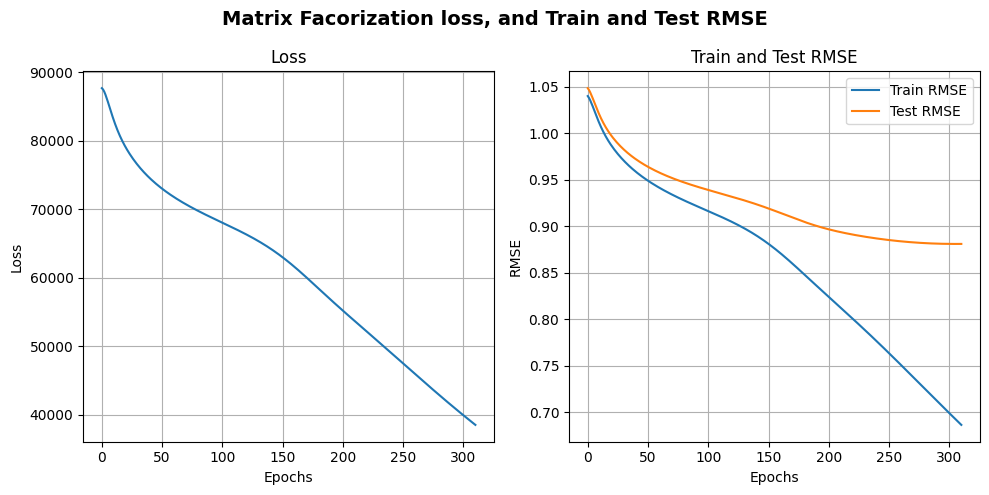

In [141]:
# plot the raining progress loss and RMSE
plot_train_progress(mf.history, "Matrix Facorization loss, and Train and Test RMSE", './img/matrix_lossrmse_evaluation_bias_final')

In [143]:
def calculate_metrics(R_test, predictions, top_n=100, relevance_threshold=4):
    """
    Calculate HR@N, NDCG@N, and MRR for rating-based recommendations,
    considering only items with a rating >= relevance_threshold as relevant.
    """
    metrics = {}

    hits = 0
    ndcg_scores = []
    reciprocal_ranks = []
    precisions = []

    total_users = R_test.shape[0]

    for user_id in range(total_users):
        # Get indices of items rated by the user in the test set
        actual_items_idx = np.where(R_test[user_id] > 0)[0]

        # Skip users with no ratings in the test set
        if len(actual_items_idx) == 0:
            continue

        # Filter items based on the relevance threshold
        relevant_mask = R_test[user_id, actual_items_idx] >= relevance_threshold

        # Skip user if no any relevant item
        if not np.any(relevant_mask):
            continue

        # Only keep relevant items and their ratings
        relevant_items_idx = actual_items_idx[relevant_mask]
        relevant_ratings = R_test[user_id, relevant_items_idx]

        # Sort relevant items by actual rating (highest first)
        sorted_order = np.argsort(relevant_ratings)[::-1]
        sorted_relevant_items = relevant_items_idx[sorted_order]
        sorted_relevant_ratings = relevant_ratings[sorted_order]

        # Get top N recommendations from the predicted ratings
        user_recs = np.argsort(predictions[user_id])[::-1][:top_n]

        # Compute metrics for this user
        user_metrics = calculate_user_metrics(
            user_recs, sorted_relevant_items, sorted_relevant_ratings, top_n
        )

        # Accumulate metrics
        if user_metrics['hit']:
            hits += 1
        ndcg_scores.append(user_metrics['ndcg'])
        reciprocal_ranks.append(user_metrics['rr'])
        precisions.append(user_metrics['precision'])

    # Calculate final metrics
    metrics['HR@N'] = hits / total_users if total_users > 0 else 0
    metrics['NDCG@N'] = np.mean(ndcg_scores) if ndcg_scores else 0
    metrics['MRR'] = np.mean(reciprocal_ranks) if reciprocal_ranks else 0
    metrics['precision@N'] = np.mean(precisions) if precisions else 0

    return metrics


def calculate_user_metrics(recommendations, actual_items, actual_ratings, top_n):
    """
    Calculate ranking-based metrics for a single user based on rating predictions.
    actual_items and actual_ratings are already filtered to contain only relevant items.
    """
    metrics = {'hit': False, 'ndcg': 0.0, 'rr': 0.0, 'precision': 0.0}

    dcg = 0
    idcg = 0
    precision = 0

    # Compute DCG: use actual ratings as relevance scores
    for rank, item in enumerate(recommendations, 1):
        # Only consider item if it's in the list of relevant items
        if item in actual_items:
            metrics['hit'] = True
            precision += 1

            if metrics['rr'] == 0:
                metrics['rr'] = 1.0 / rank

            # Retrieve the relevance score for this item
            relevance = actual_ratings[np.where(actual_items == item)][0]
            dcg += relevance / np.log2(rank + 1)

    # Compute Ideal DCG (IDCG): ideal ranking of relevant items by their ratings
    sorted_ratings = np.sort(actual_ratings)[::-1]  # highest ratings first
    ideal_ranks = np.arange(1, min(len(actual_items), top_n) + 1)
    idcg = np.sum(sorted_ratings[:top_n] / np.log2(ideal_ranks + 1))

    # Avoid division by zero in NDCG
    metrics['ndcg'] = dcg / idcg if idcg > 0 else 0

    # Precision
    metrics['precision'] = precision / top_n

    return metrics

def evaluate_complete(R_test, predictions, top_ns=[5, 10, 20, 50, 100], relevance_threshold=3):
    """
    Evaluate recommendations with multiple N values.
    """
    results = {}

    for n in top_ns:
        metrics = calculate_metrics(R_test, predictions, top_n=n, relevance_threshold=relevance_threshold)
        results[f'top_{n}'] = metrics

    return results

def print_evaluation_results(results):
    """
    Print the evaluation results.
    """
    print("\nEvaluation Results:")
    print("-" * 50)
    for n, metrics in results.items():
        print(f"\nMetrics for {n}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")



Evaluation Results:
--------------------------------------------------

Metrics for top_5:
HR@N: 0.2623
NDCG@N: 0.0597
MRR: 0.1374
precision@N: 0.0602

Metrics for top_10:
HR@N: 0.4180
NDCG@N: 0.0641
MRR: 0.1584
precision@N: 0.0576

Metrics for top_20:
HR@N: 0.5967
NDCG@N: 0.0764
MRR: 0.1717
precision@N: 0.0540

Metrics for top_50:
HR@N: 0.7541
NDCG@N: 0.1017
MRR: 0.1768
precision@N: 0.0453

Metrics for top_100:
HR@N: 0.8459
NDCG@N: 0.1271
MRR: 0.1781
precision@N: 0.0367


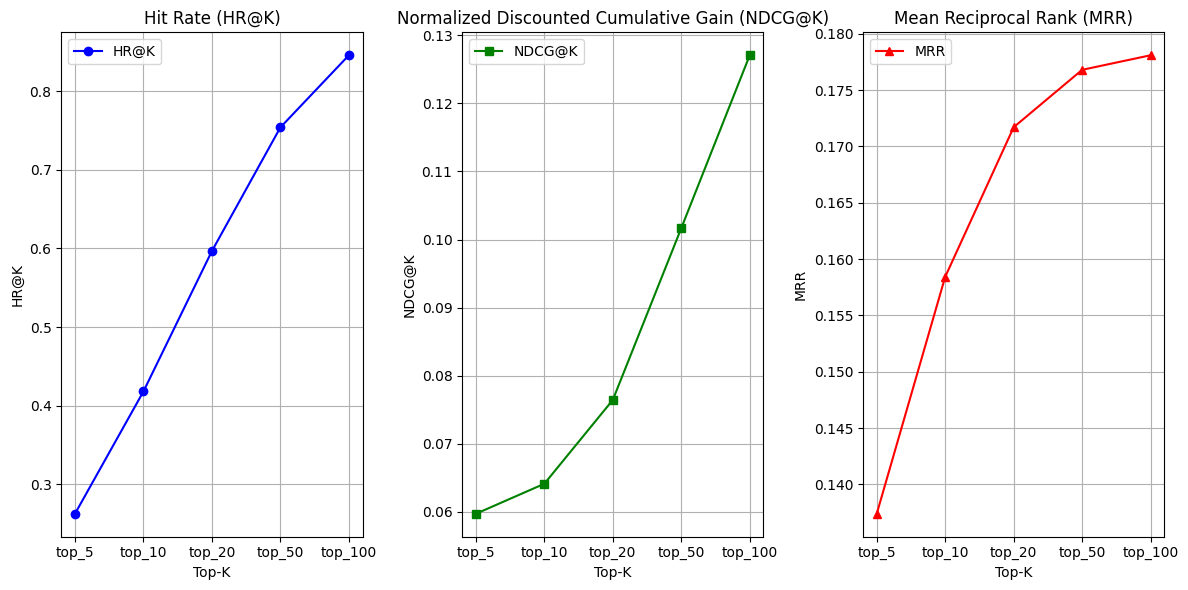

In [144]:
# print and plot rank metrics
test_results_mat = evaluate_complete(R_test, mf.predict_all())
print_evaluation_results(test_results_mat)
plot_rank_metric(test_results_mat, './img/matrix_factorization_evaluation_bias_final')

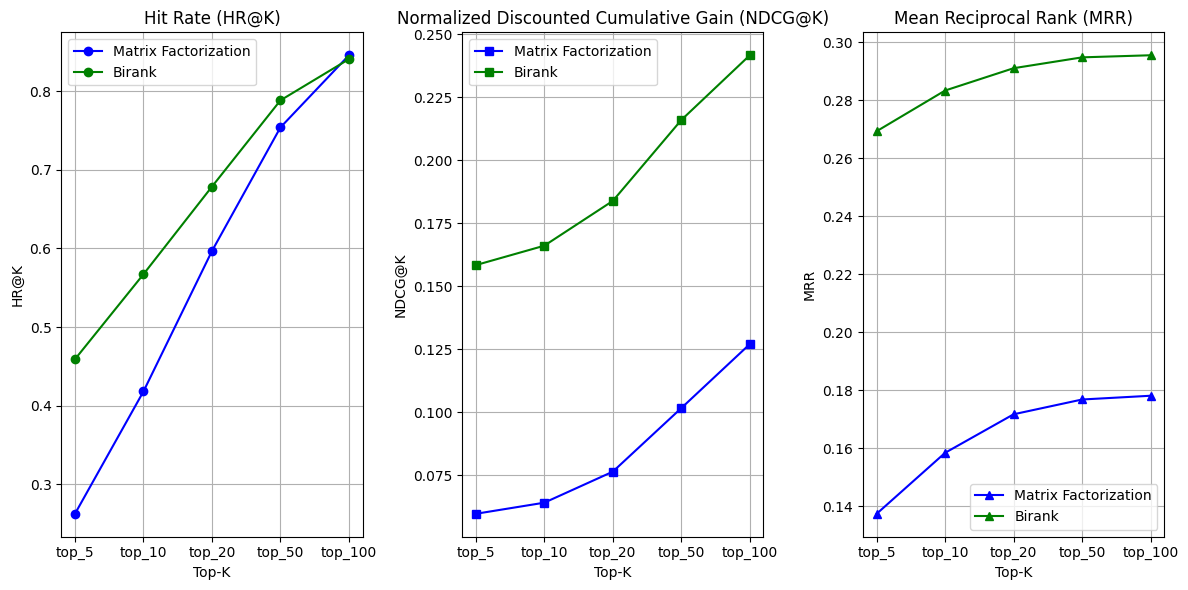

In [145]:
# plot birank and matrix factorization ranking metrices
plot_rank_metric_both(birank_test_result=test_results_birank, test_results=test_results_mat,
                     file_name ='./img/matrix_factorization_birank_evaluation')

#### Demo

In [146]:
predictions_df = pd.DataFrame(predictions,
                              columns=ratings_100k['movieId'].unique(),
                              index=ratings_100k['userId'].unique())

# Reset index to have 'userId' as a column
user_preds_df = predictions_df.reset_index().melt(id_vars="index", var_name="movieId", value_name="rating")

# Rename 'index' to 'userId'
user_preds_df.rename(columns={"index": "userId"}, inplace=True)
user_preds_df.head()

,userId,movieId,rating
0,1,1,4.427789
1,2,1,3.969908
2,3,1,3.134524
3,4,1,3.992624
4,5,1,3.800416
